In [390]:
#Evan Jarman 12/2/22
#This will be an analysis of Covid-19. 
#The goal of this analysis is to use the variables present with strong correlations with death due to covid,
#then a model will be fit to predict covid deaths in future patients

# ABOUT THE DATA
#Contains a vast number of anonymized patient-related information including pre-conditions.
#The raw dataset consists of 21 different features and 1,048,576 unique patients. 
#In the Boolean features, 1 means "yes" and 2 means "no". values as 97 and 99 are missing data.

In [391]:
# LIBRARIES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix

# IMPORT WARNINGS (TO IGNORE FILTER WARNINGS)

import warnings
warnings.filterwarnings("ignore")

In [392]:
# READ IN DATA

data = pd.read_csv('.../Covid Data.csv')

In [393]:
# GET INITIAL LOOK AT DATA

print('Shape of the dataframe:', data.shape, '\n')
data.head()

Shape of the dataframe: (1048575, 21) 



,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


In [394]:
#USMER - how severe the medical intervention was 
#SEX - gender, 1 - female, 2 - male
#MEDICAL_UNIT - what type of medical institution patient was treated at
#PATIENT_TYPE - hospitalized or not
#DATE_DIED - 9999-99-99 if patient recovered
#CLASSIFFICATION_FINAL - covid test results, <4 means tested positive for covid, >4 means tested negative for covid
#values 97 and 99 are missing data
# 1 = yes, 2 = no

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   USMER                 1048575 non-null  int64 
 1   MEDICAL_UNIT          1048575 non-null  int64 
 2   SEX                   1048575 non-null  int64 
 3   PATIENT_TYPE          1048575 non-null  int64 
 4   DATE_DIED             1048575 non-null  object
 5   INTUBED               1048575 non-null  int64 
 6   PNEUMONIA             1048575 non-null  int64 
 7   AGE                   1048575 non-null  int64 
 8   PREGNANT              1048575 non-null  int64 
 9   DIABETES              1048575 non-null  int64 
 10  COPD                  1048575 non-null  int64 
 11  ASTHMA                1048575 non-null  int64 
 12  INMSUPR               1048575 non-null  int64 
 13  HIPERTENSION          1048575 non-null  int64 
 14  OTHER_DISEASE         1048575 non-null  int64 
 15

In [395]:

print('Total null cells:', data.isnull().sum().sum(), '\n')

print('Total "99" values:', (data[:] == 99).sum().sum(), '\n')

print('Total "97" values:', (data[:] == 97).sum().sum(), '\n')

Total null cells: 0 

Total "99" values: 30902 

Total "97" values: 2220734 



In [396]:
# PROCESS / CLEAN DATA

#fix spelling error in column title
data = data.rename(columns = {'CLASIFFICATION_FINAL' : 'CLASSIFICATION_FINAL'})

#change null pregnant data for males to 'no' / 2
data.loc[data.SEX == 2, 'PREGNANT'] = 2

#delete rows with missing data
data = data[data[:] != 97].dropna()
data = data[data[:] != 99].dropna()

#add binary 'DIED' column to data frame
data['DIED'] = (data.DATE_DIED != '9999-99-99').astype(int).replace(0,2)

#change classiffication_final column to binary
data['CLASSIFICATION_FINAL_BINARY'] = data.CLASSIFICATION_FINAL.replace([[1,2,3], [4,5,6,7]], [1, 2])

print('New dataframe shape:', data.shape, '\n')

data.head(10)

New dataframe shape: (192428, 23) 



,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASSIFICATION_FINAL,ICU,DIED,CLASSIFICATION_FINAL_BINARY
2,2,1,2,2,09/06/2020,1.0,2.0,55.0,2,1,...,2,2,2,2,2,2,3,2.0,1,1
5,2,1,1,2,9999-99-99,2.0,1.0,40.0,2,2,...,2,2,2,2,2,2,3,2.0,2,1
8,2,1,1,2,9999-99-99,2.0,2.0,37.0,2,1,...,1,2,2,1,2,2,3,2.0,2,1
9,2,1,1,2,9999-99-99,2.0,2.0,25.0,2,2,...,2,2,2,2,2,2,3,2.0,2,1
11,2,1,2,2,9999-99-99,2.0,2.0,24.0,2,2,...,2,2,2,2,2,2,3,2.0,2,1
12,2,1,2,2,9999-99-99,2.0,2.0,30.0,2,2,...,2,2,2,2,2,2,3,2.0,2,1
16,2,1,1,2,9999-99-99,2.0,1.0,80.0,2,2,...,1,2,2,2,2,2,3,1.0,2,1
20,2,1,2,2,9999-99-99,2.0,1.0,59.0,2,1,...,2,2,2,2,2,1,3,1.0,2,1
30,2,1,2,2,9999-99-99,2.0,1.0,45.0,2,2,...,2,2,2,2,2,2,3,2.0,2,1
41,2,1,2,2,9999-99-99,1.0,1.0,45.0,2,2,...,2,2,2,2,2,2,3,1.0,2,1


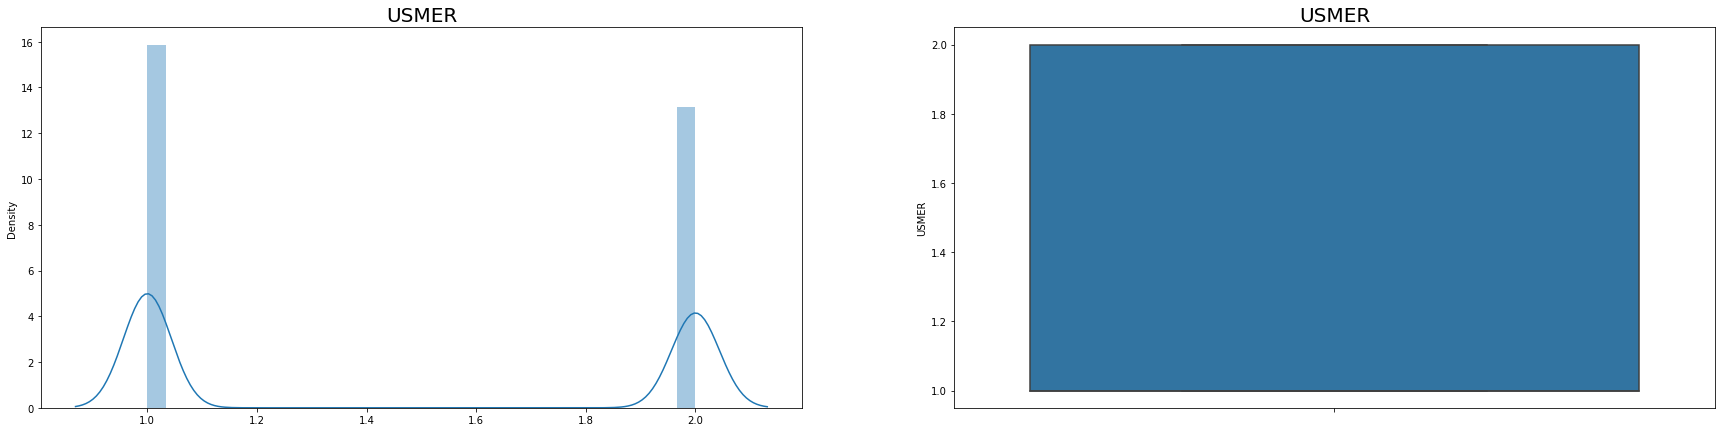

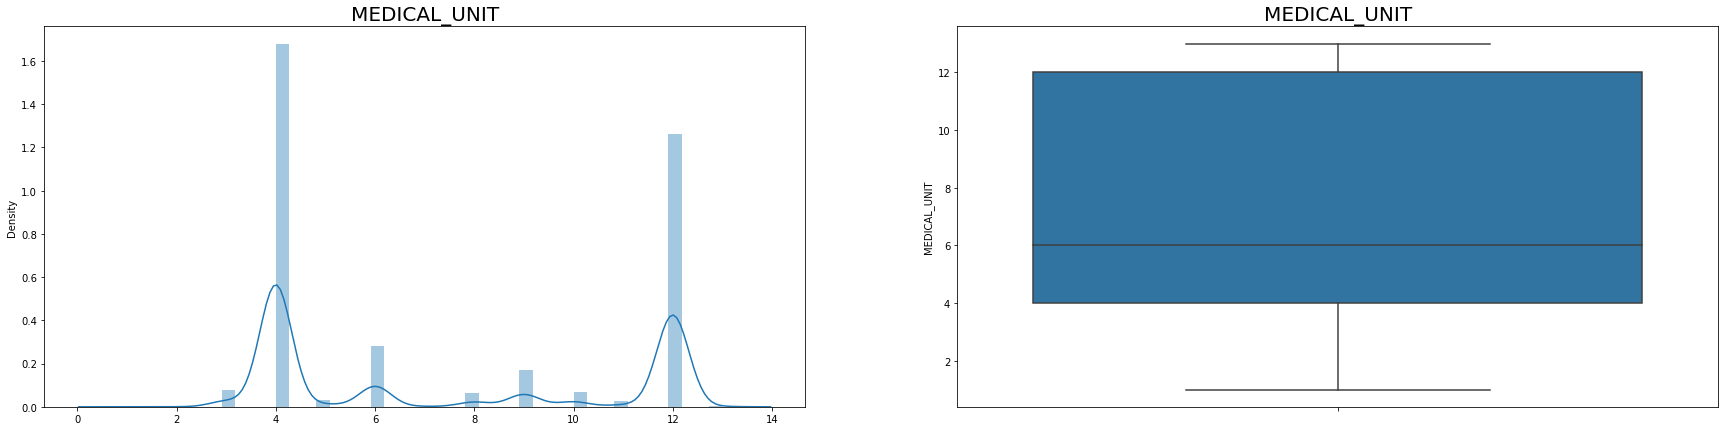

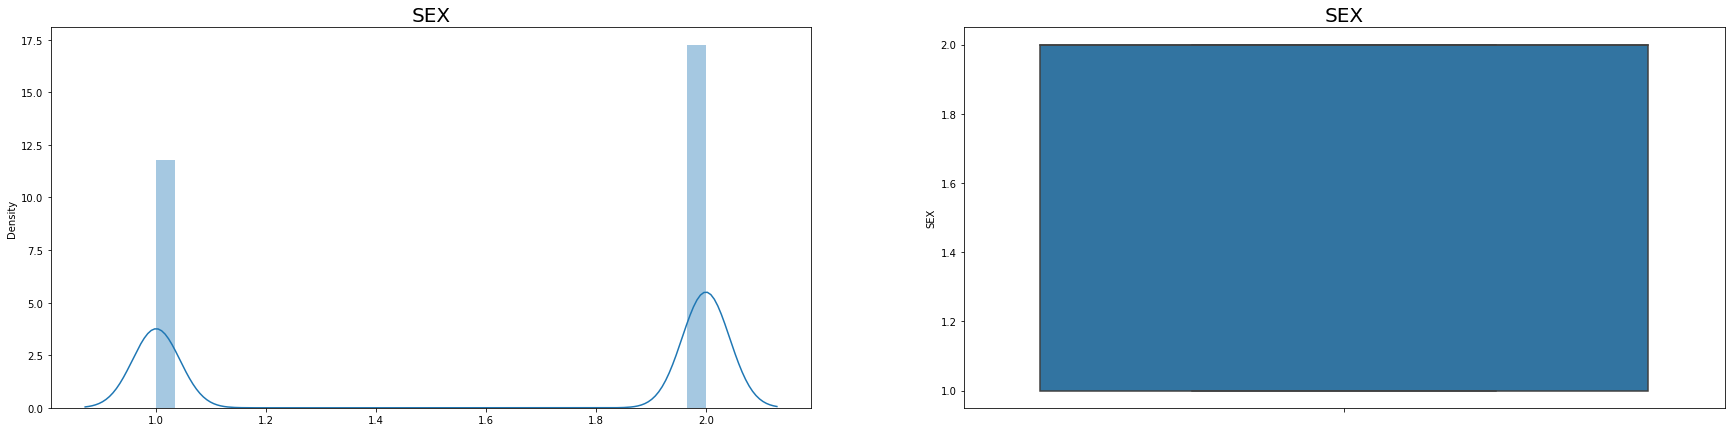

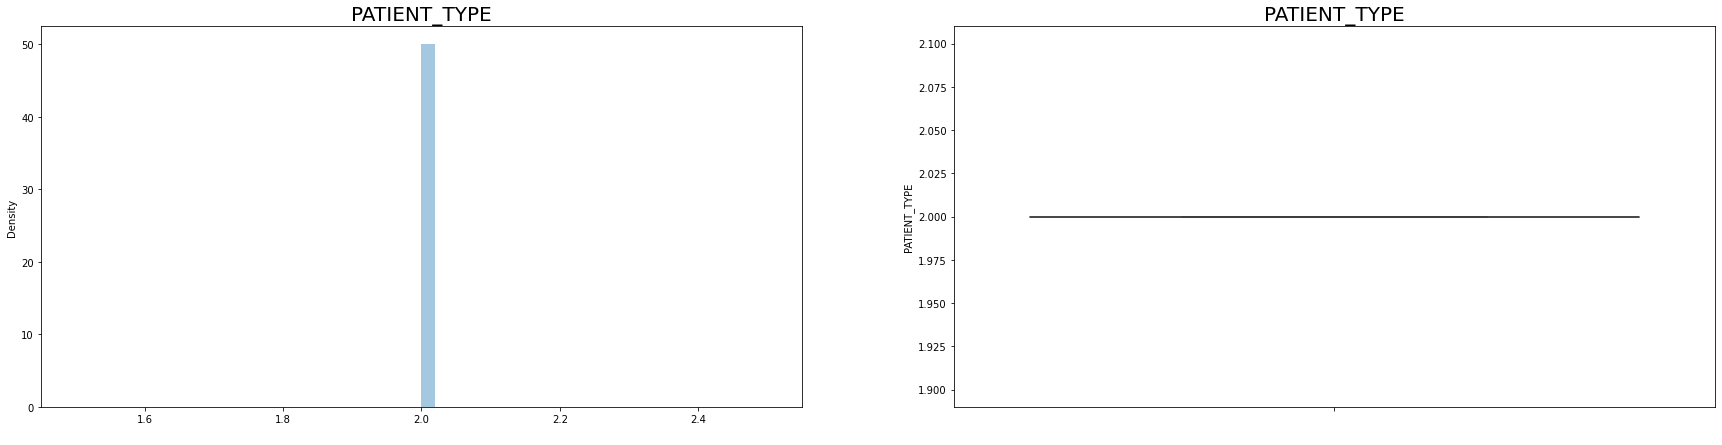

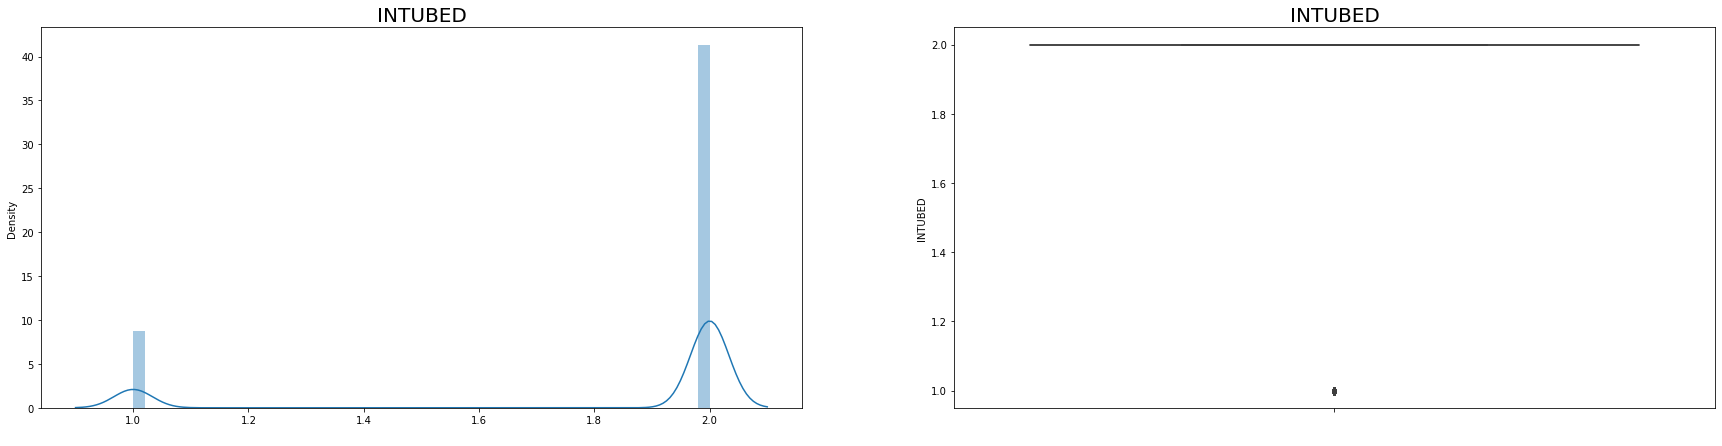

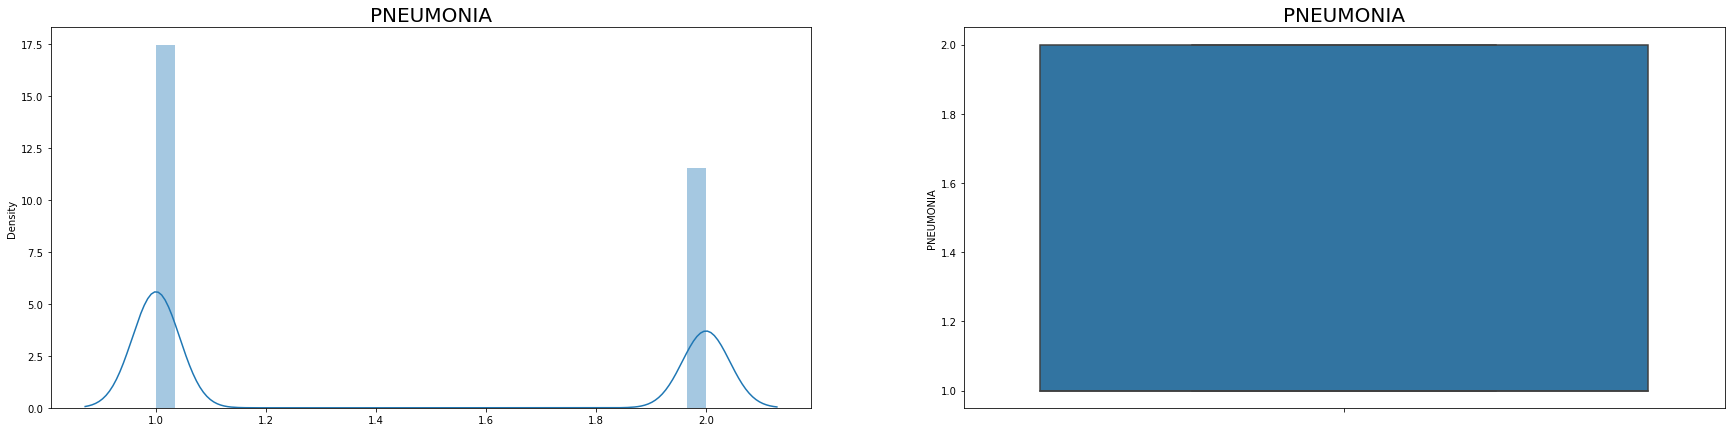

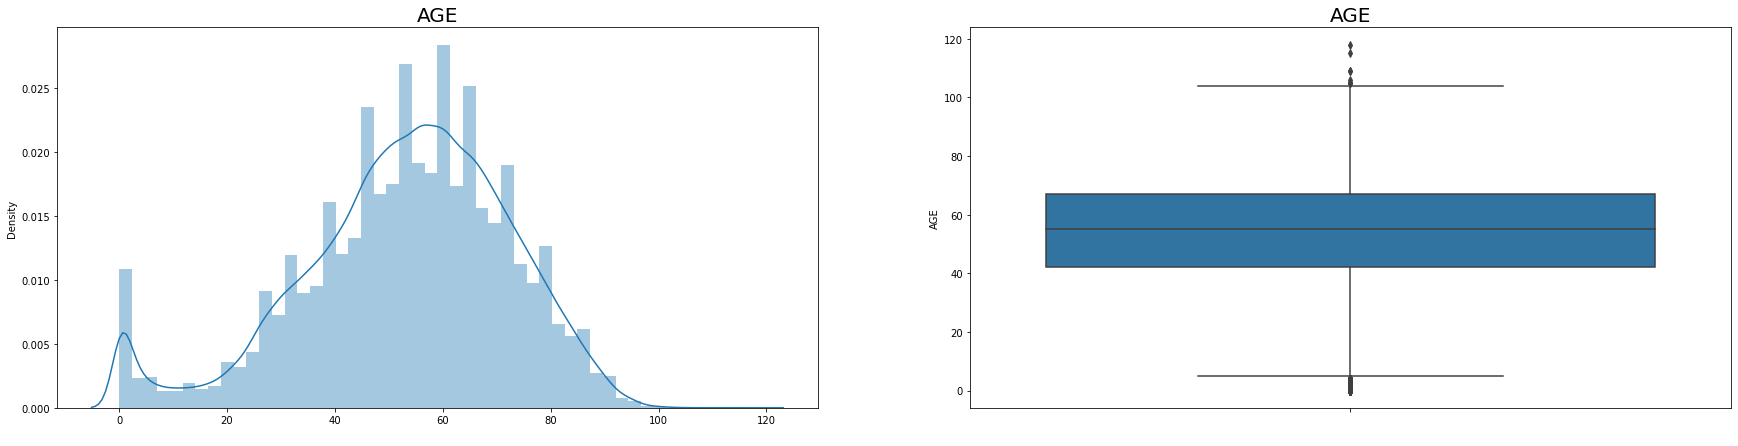

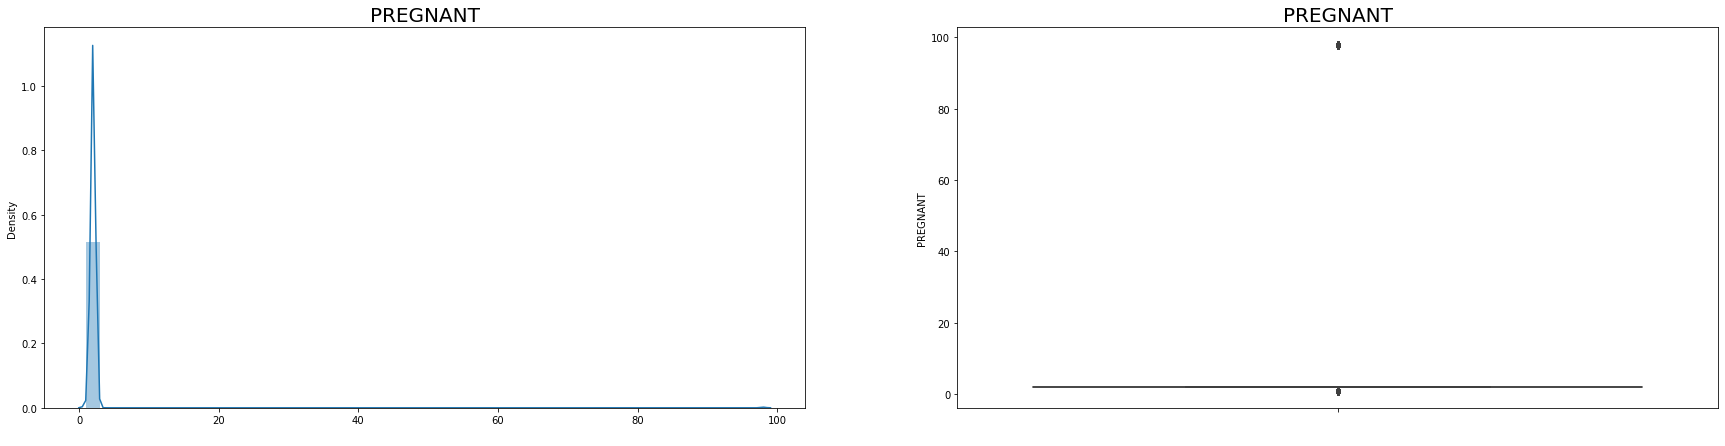

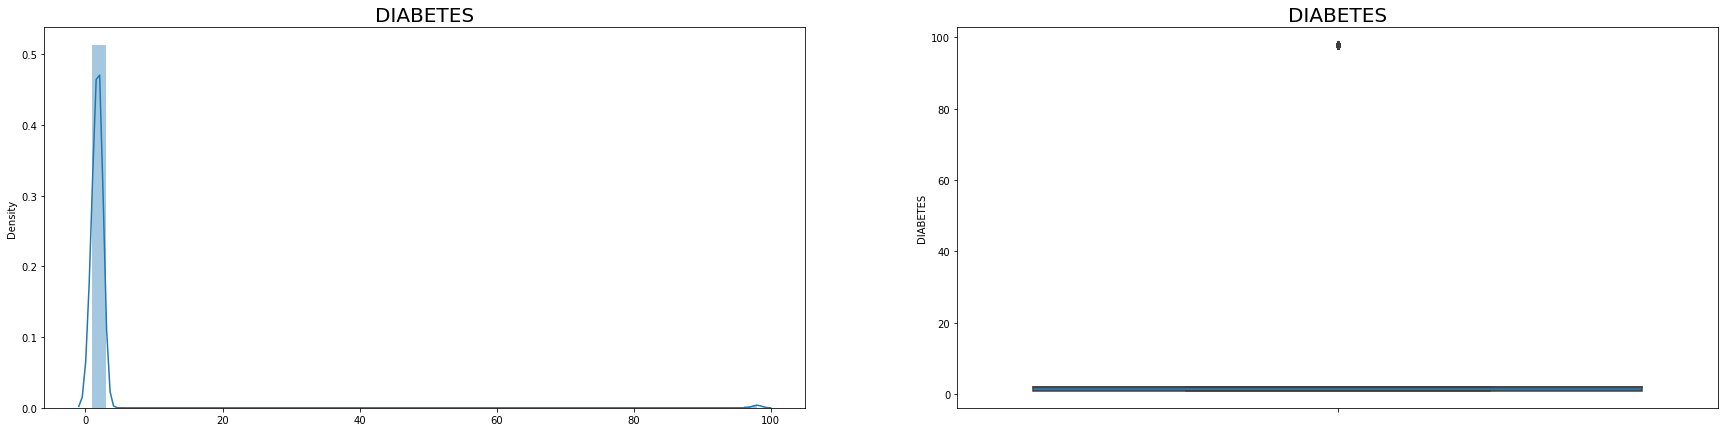

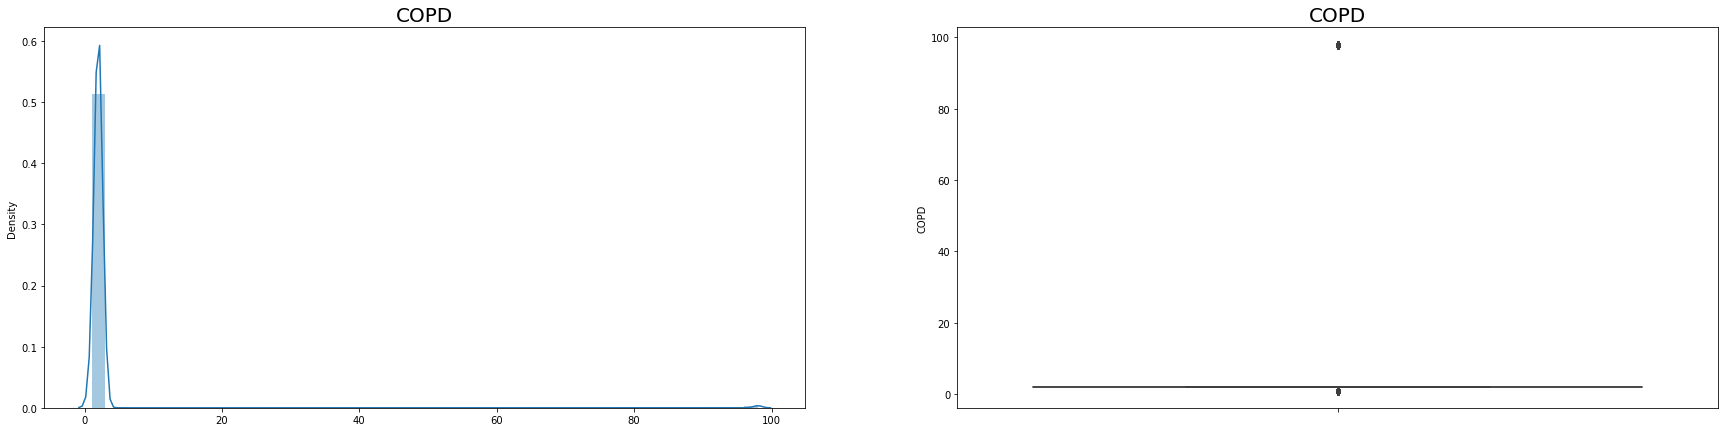

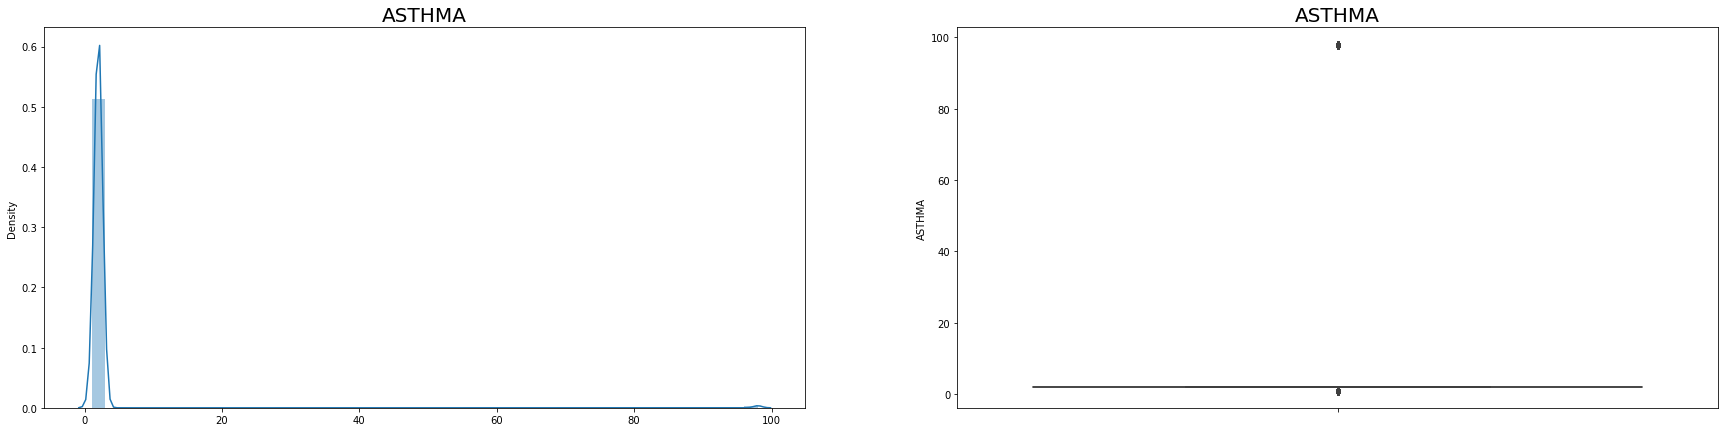

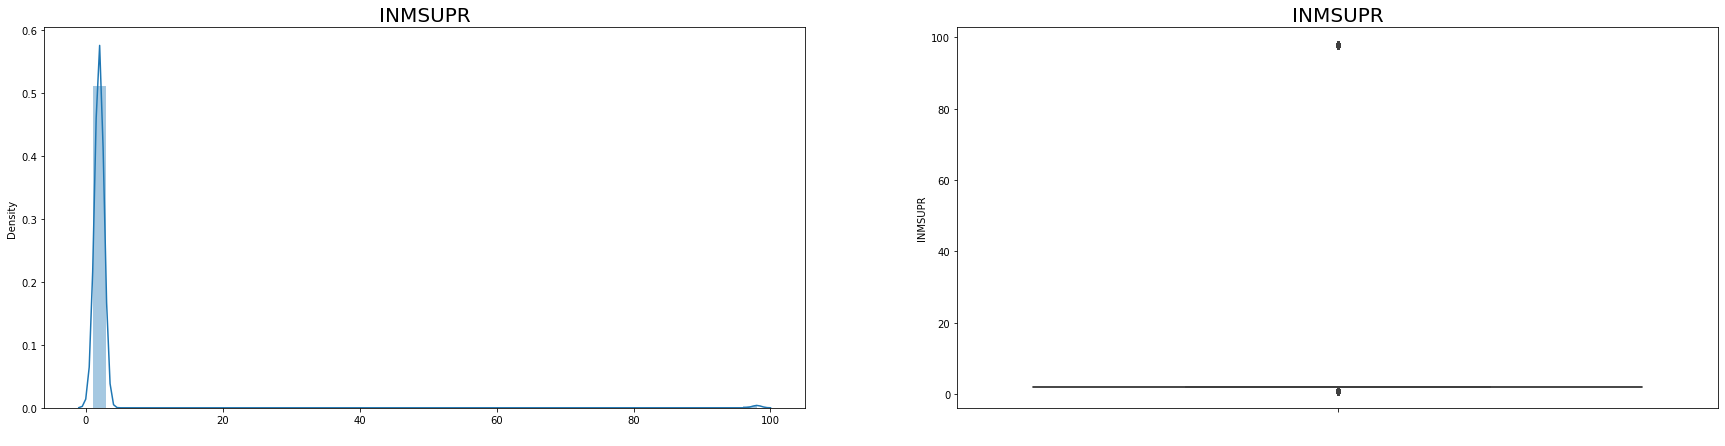

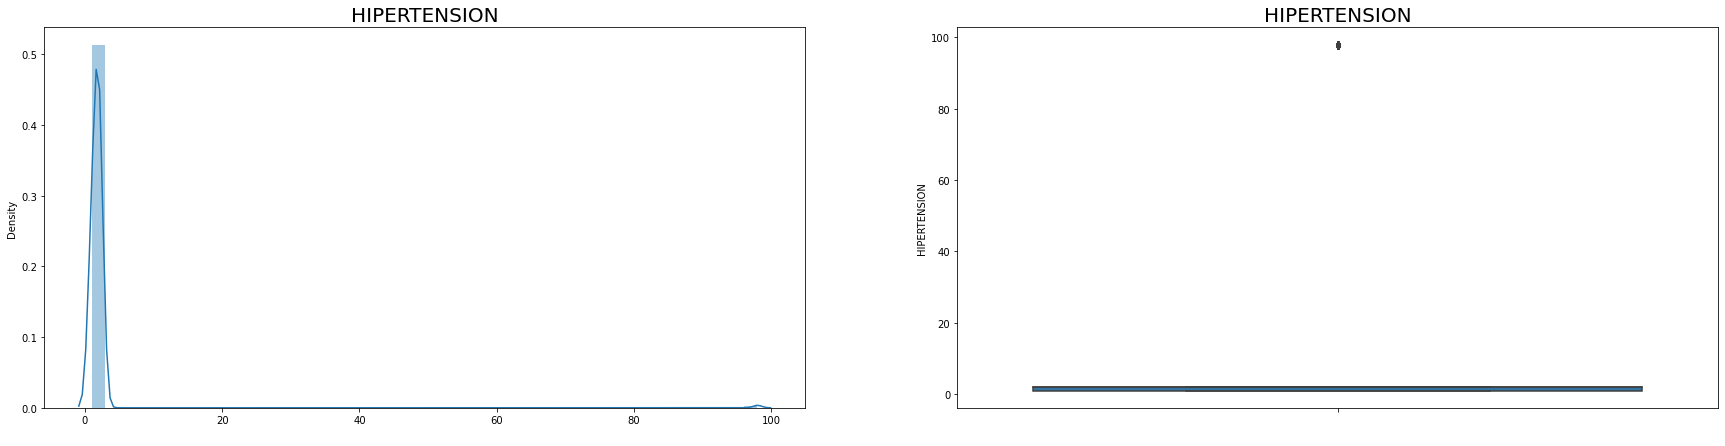

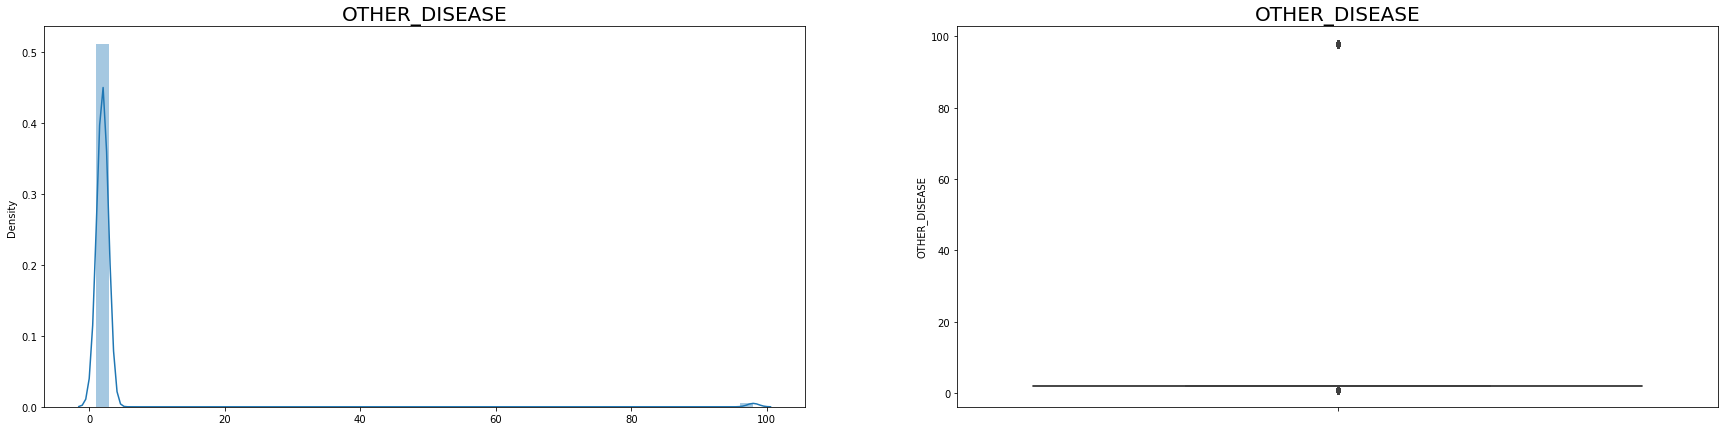

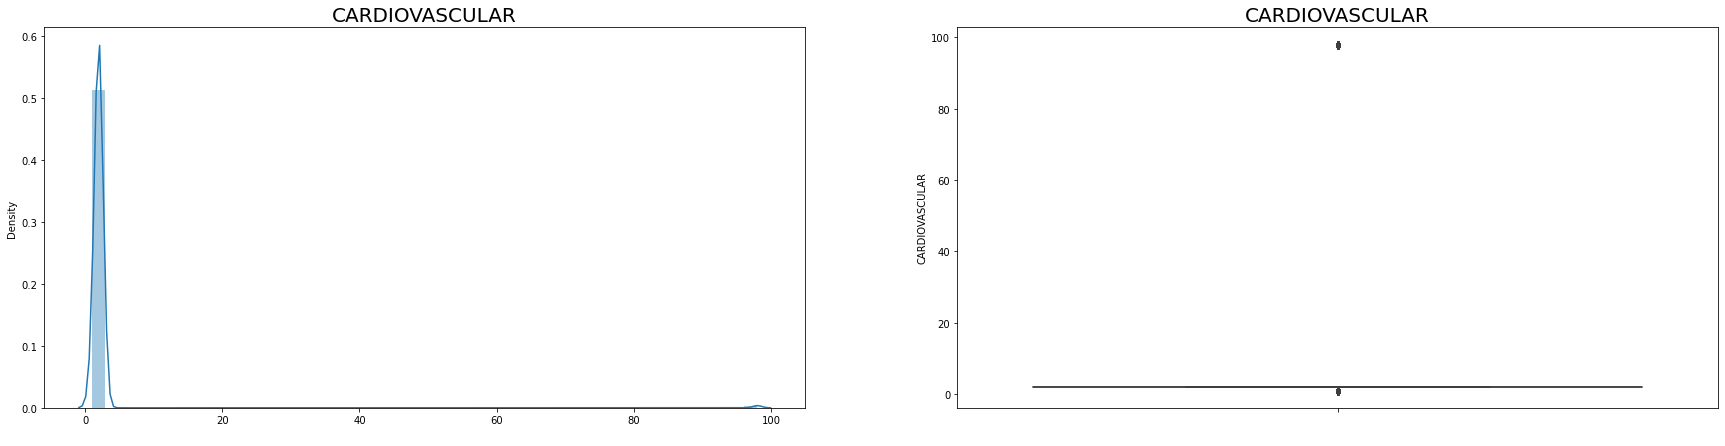

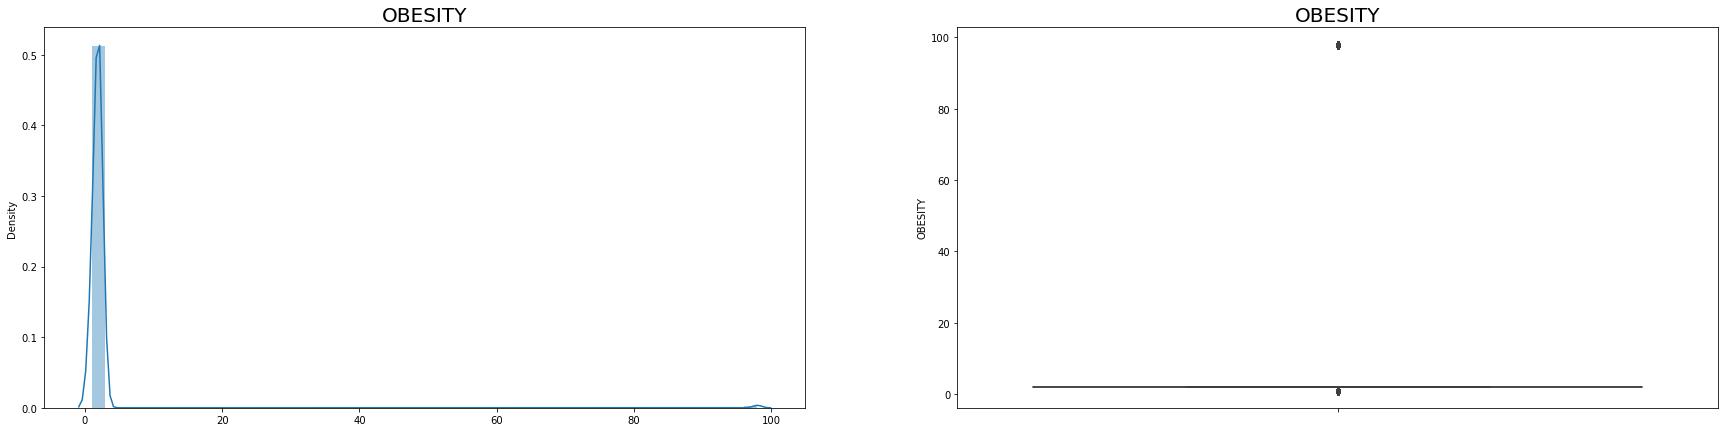

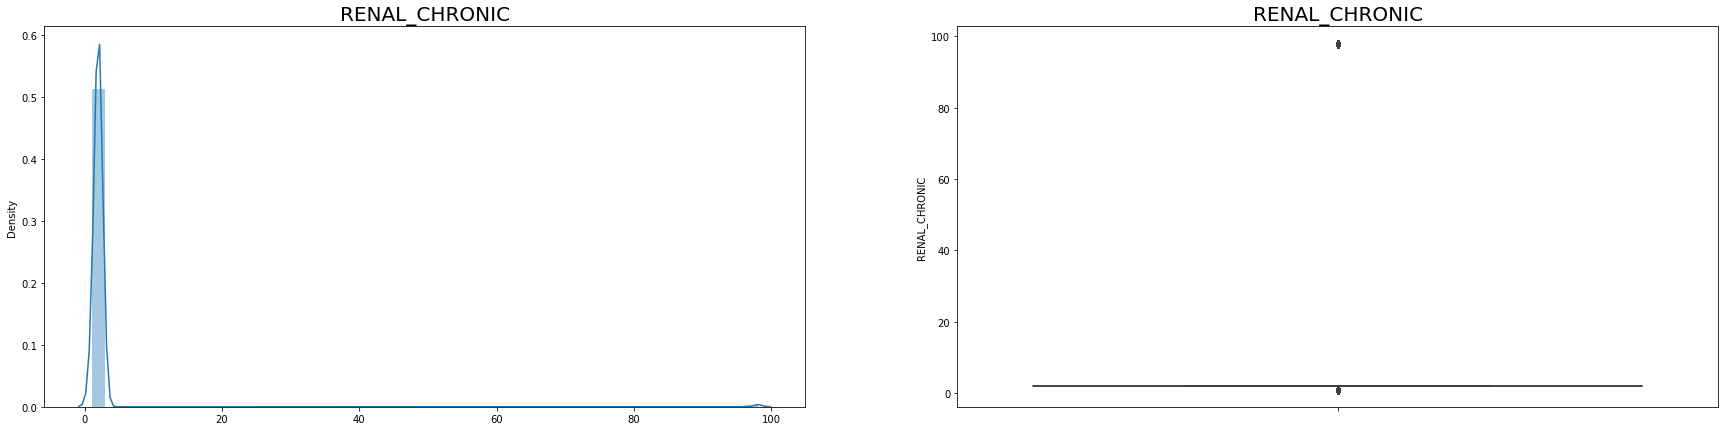

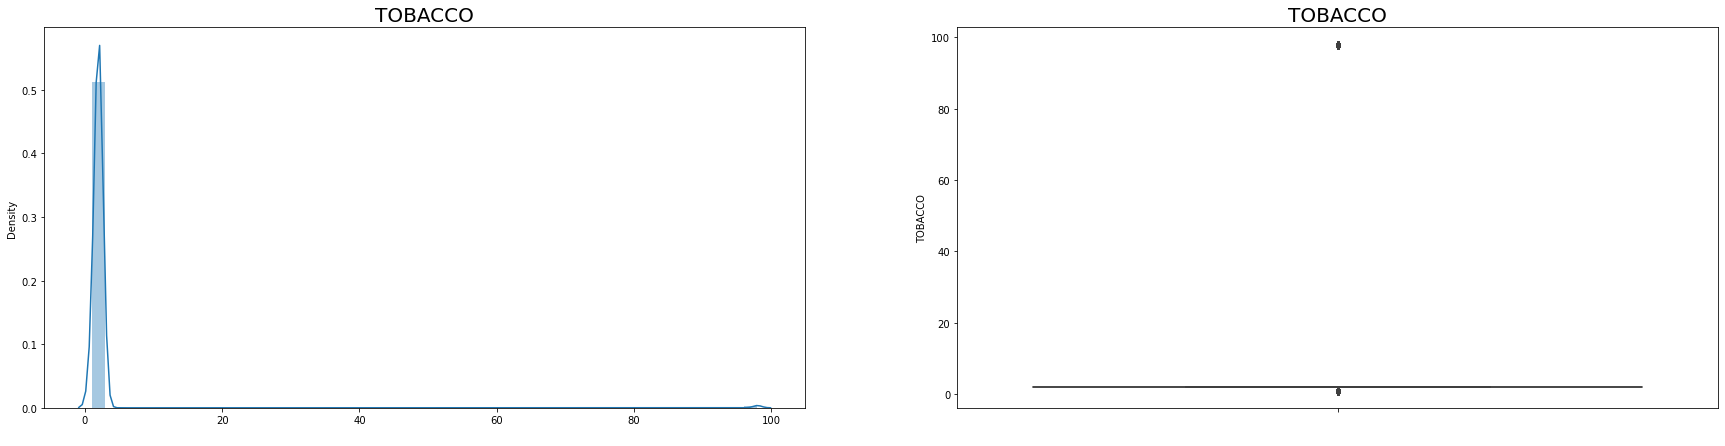

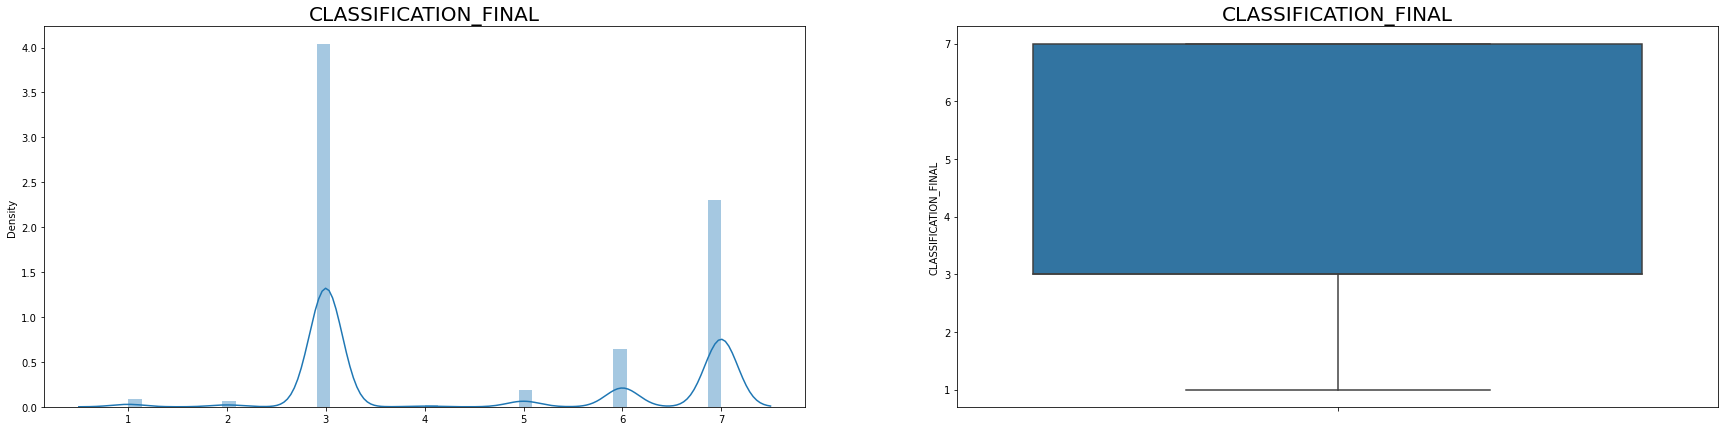

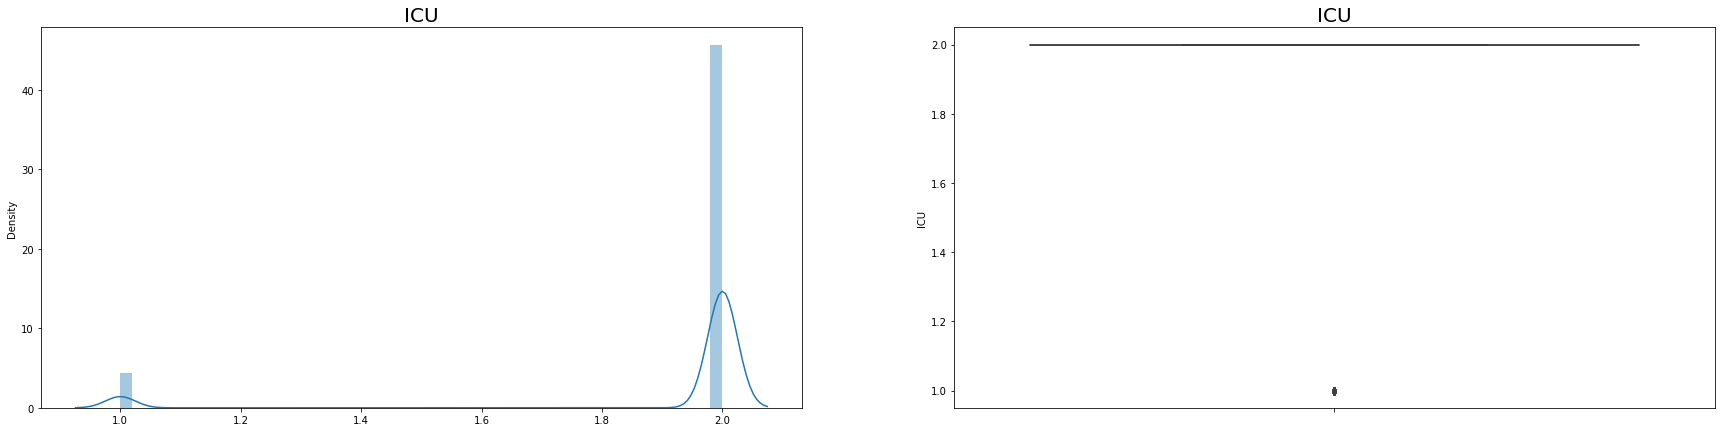

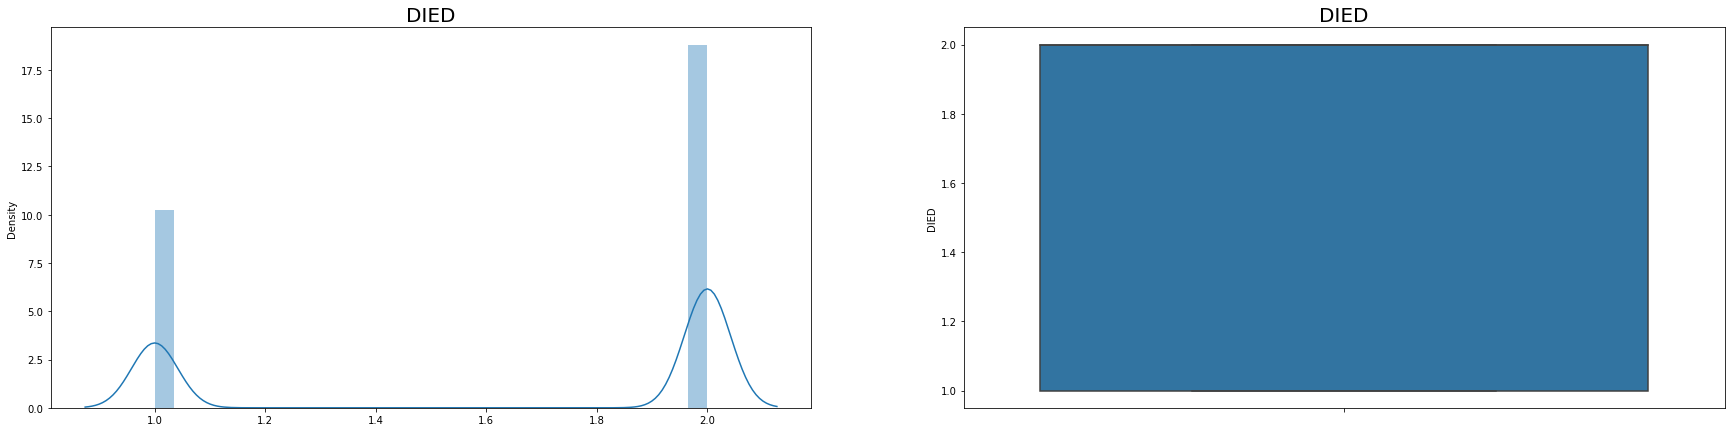

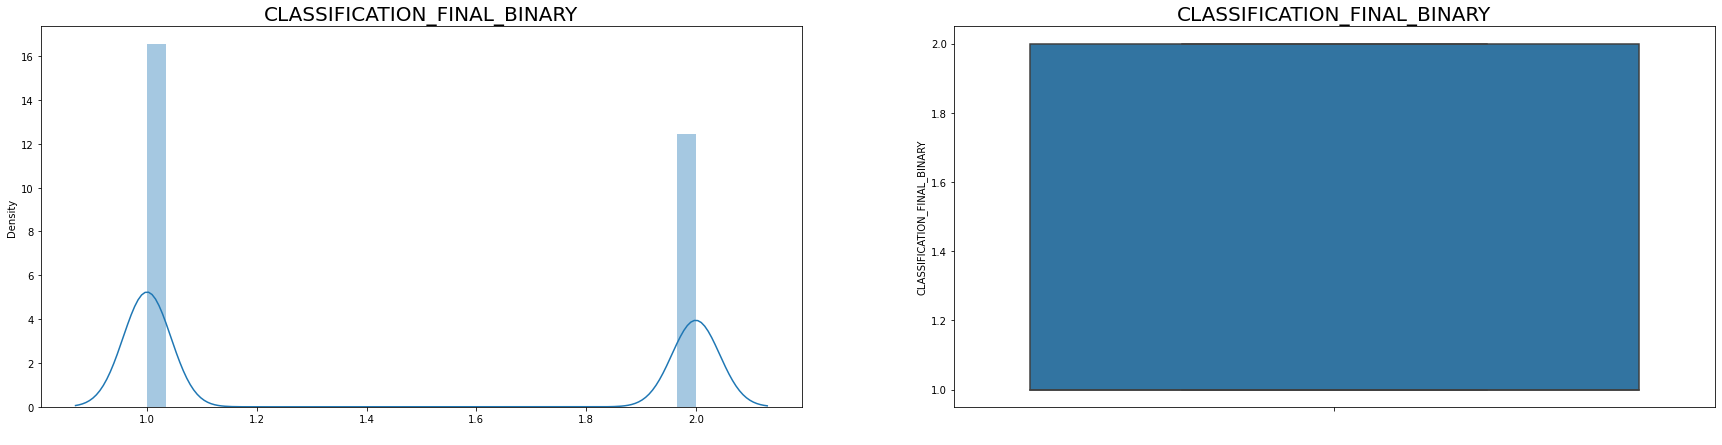

In [397]:
# BEGIN ANALYSIS

#create histograms of each column
var = data.drop(columns = 'DATE_DIED')

for index, col in enumerate(var.columns):
    plt.figure(figsize = (30,7))
    plt.subplot(1,2,1)
    sns.distplot(var[col])
    plt.xlabel(" ")
    plt.title(col, size = 20)
    
    plt.subplot(1,2,2)
    sns.boxplot(y = var[col])
    plt.title(col, size = 20)
    plt.show()

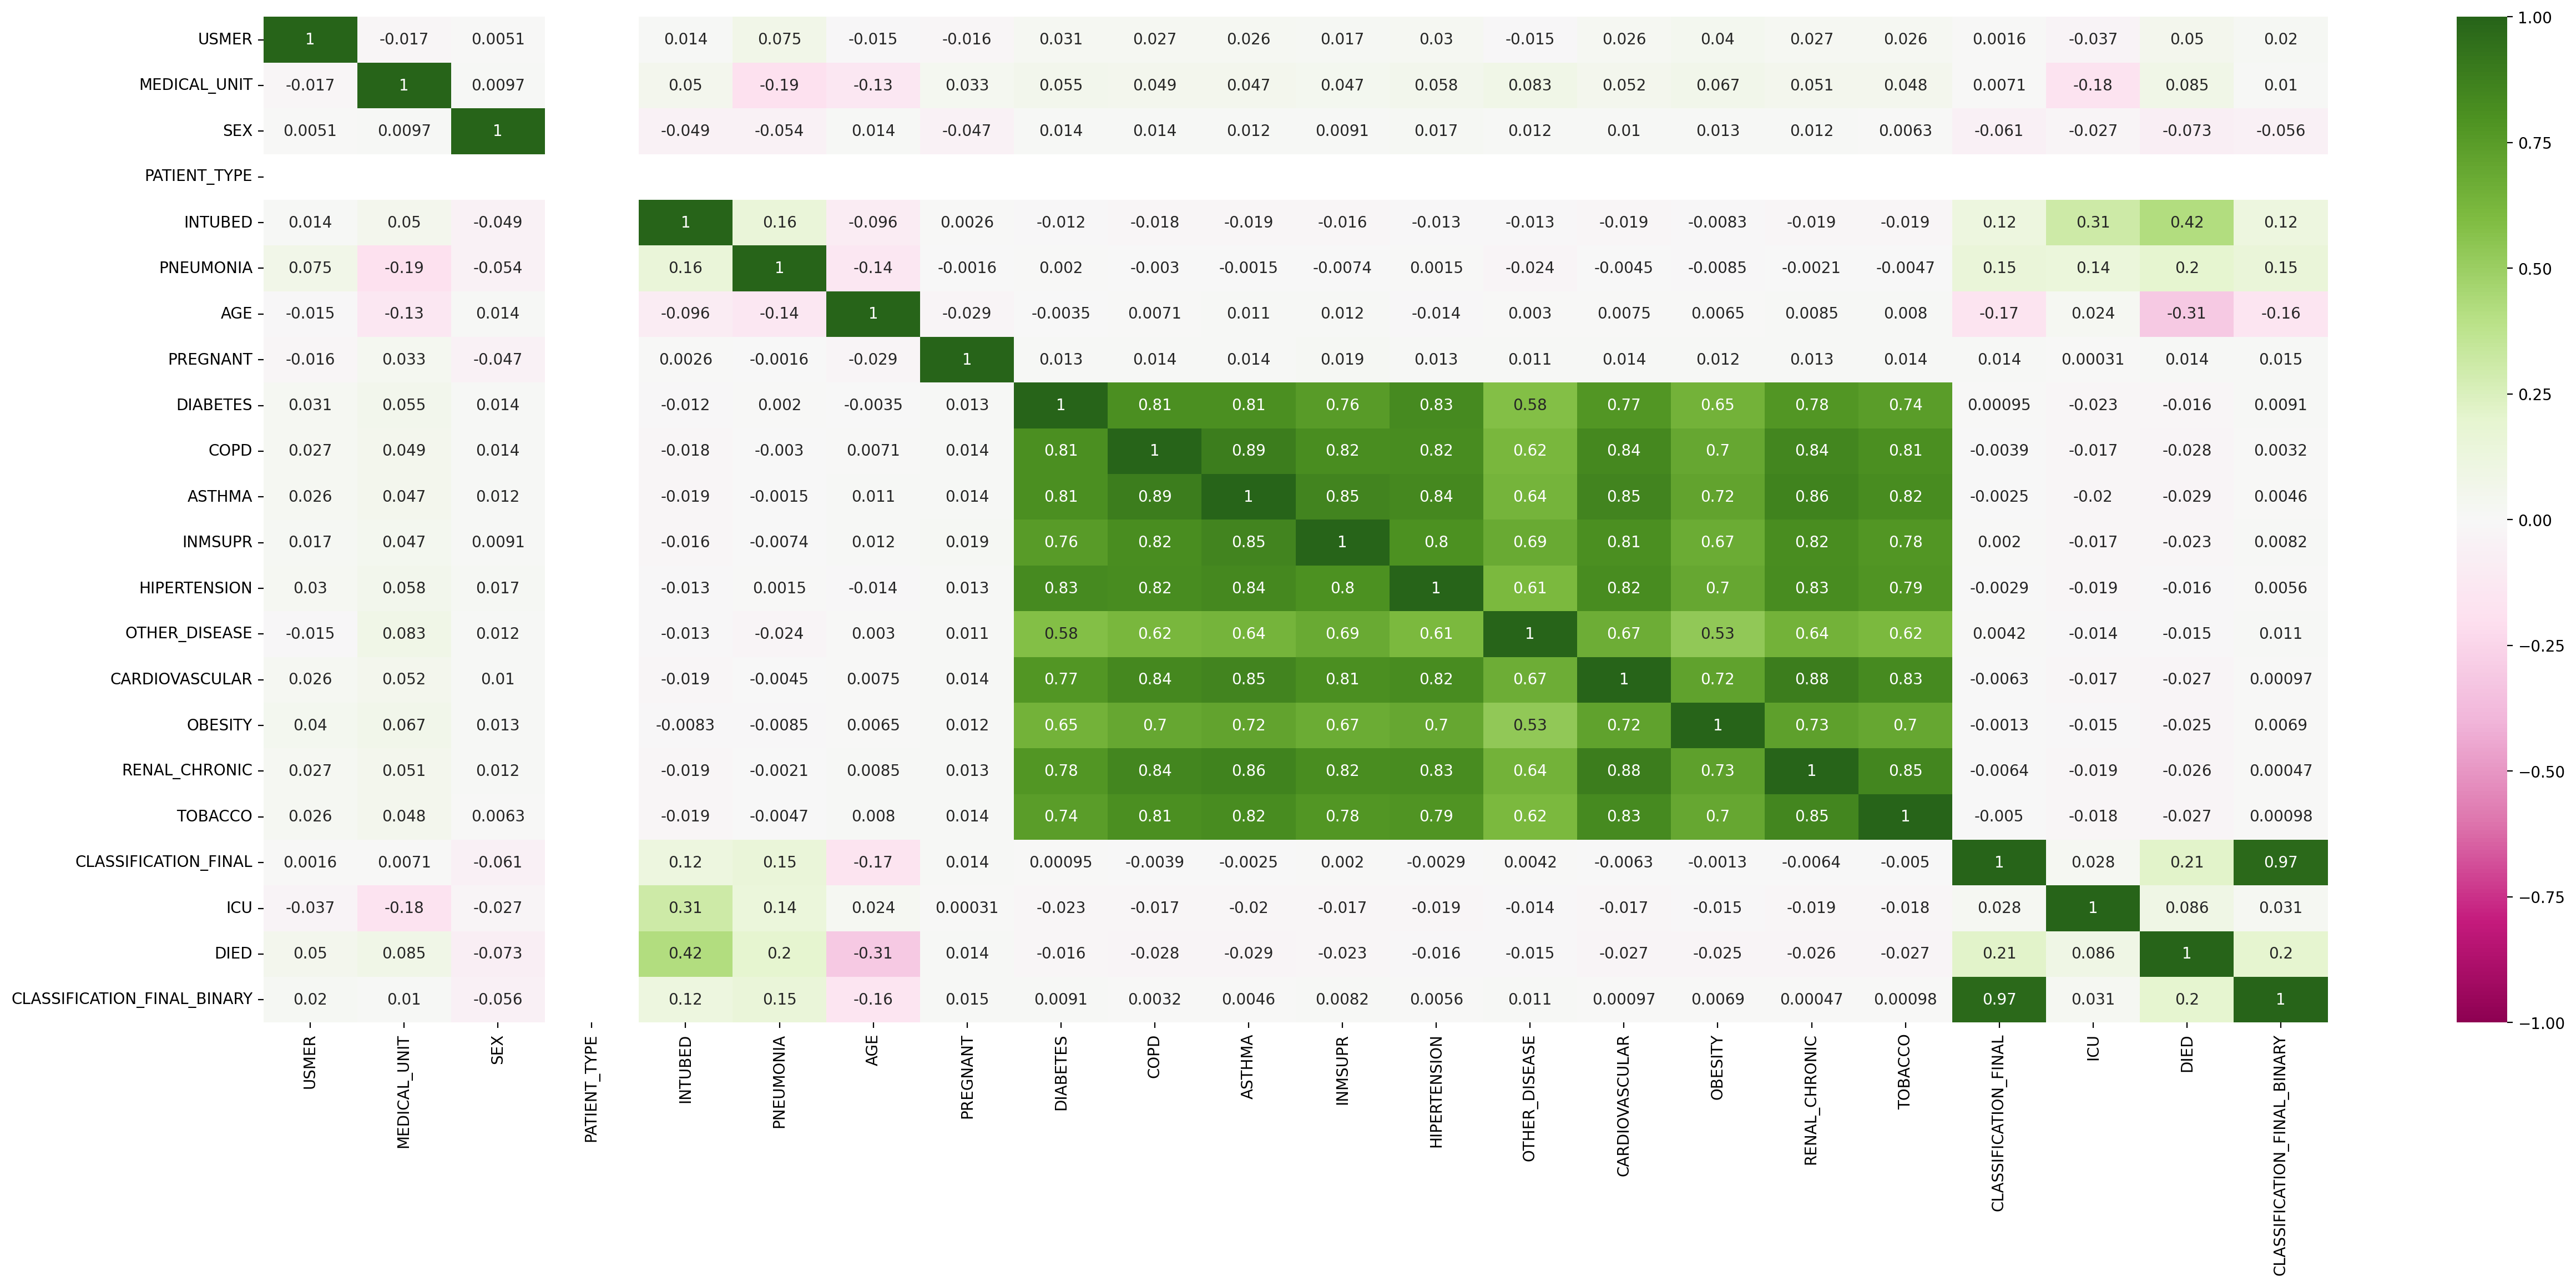

USMER                          0.050328
MEDICAL_UNIT                   0.085213
SEX                           -0.072945
PATIENT_TYPE                        NaN
INTUBED                        0.415700
PNEUMONIA                      0.197047
AGE                           -0.306064
PREGNANT                       0.013613
DIABETES                      -0.016088
COPD                          -0.028413
ASTHMA                        -0.028519
INMSUPR                       -0.023028
HIPERTENSION                  -0.015515
OTHER_DISEASE                 -0.014818
CARDIOVASCULAR                -0.026808
OBESITY                       -0.025043
RENAL_CHRONIC                 -0.025619
TOBACCO                       -0.026596
CLASSIFICATION_FINAL           0.213857
ICU                            0.086260
DIED                           1.000000
CLASSIFICATION_FINAL_BINARY    0.202450
Name: DIED, dtype: float64


In [398]:
# create pearson correlation matrix of all variables
plt.figure(figsize = (30,12), dpi = 200)
sns.heatmap(data.corr(), annot = True, vmin = -1, vmax = +1, cmap = "PiYG")
plt.show()

#find pearson correlation between patient death and all other variables
print(data.corr(method = 'pearson')['DIED'])

              precision    recall  f1-score   support

           1       0.75      0.50      0.60     20357
           2       0.77      0.91      0.83     37372

    accuracy                           0.76     57729
   macro avg       0.76      0.70      0.71     57729
weighted avg       0.76      0.76      0.75     57729



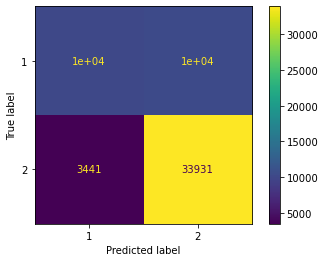

In [399]:
# FIT LOGISTIC REGRESSION TO DATA

x_train, x_test, y_train, y_test = train_test_split(data.drop(columns = ['DIED', 'CLASSIFICATION_FINAL_BINARY', 'DATE_DIED']), data.DIED, test_size = 0.3, random_state = 101)

SS = StandardScaler()

x_train=SS.fit_transform(x_train)
x_test=SS.transform(x_test)

log_model = LogisticRegression()
log_model.fit(x_train,y_train)

y_pred_log = log_model.predict(x_test)


# Assess model, plot assessment

plot_confusion_matrix(log_model,x_test,y_test)

print(classification_report(y_test,y_pred_log))



In [400]:
# TUNE HYPERPARAMETERS (USING GRIDSEARCHCV)

model = LogisticRegression()

#set params to run through
max_iter = [5000]
C = np.logspace(0, 5, num = 20)
solver = ['liblinear', 'sag', 'saga']
penalty = ['l2']
l1_ratio = [0, 0.2, 0.4, 0.6, 0.8, 1]

param_grid = {'C': C ,
             "solver": solver,
             "penalty": penalty,
             "l1_ratio": l1_ratio,
             'max_iter': max_iter}

grid_model = GridSearchCV(model, param_grid = param_grid, cv = 3, verbose = 0, n_jobs = -1)

grid_model.fit(x_train, y_train)


/Users/evanjarman/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
/Users/evanjarman/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
/Users/evanjarman/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
/Users/evanjarman/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
/Users/evanjarman/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model

GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.00000000e+00, 1.83298071e+00, 3.35981829e+00, 6.15848211e+00,
       1.12883789e+01, 2.06913808e+01, 3.79269019e+01, 6.95192796e+01,
       1.27427499e+02, 2.33572147e+02, 4.28133240e+02, 7.84759970e+02,
       1.43844989e+03, 2.63665090e+03, 4.83293024e+03, 8.85866790e+03,
       1.62377674e+04, 2.97635144e+04, 5.45559478e+04, 1.00000000e+05]),
                         'l1_ratio': [0, 0.2, 0.4, 0.6, 0.8, 1],
                         'max_iter': [5000], 'penalty': ['l2'],
                         'solver': ['liblinear', 'sag', 'saga']})

The best estimators are: LogisticRegression(C=784.7599703514607, l1_ratio=0.2, max_iter=5000,
                   solver='saga') 

The best params are: {'C': 784.7599703514607, 'l1_ratio': 0.2, 'max_iter': 5000, 'penalty': 'l2', 'solver': 'saga'} 

              precision    recall  f1-score   support

           1       0.75      0.50      0.60     20357
           2       0.77      0.91      0.83     37372

    accuracy                           0.76     57729
   macro avg       0.76      0.70      0.71     57729
weighted avg       0.76      0.76      0.75     57729



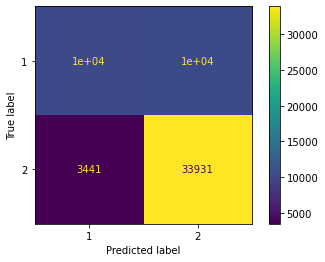

In [401]:
#assess tuned model
print('The best estimators are:', grid_model.best_estimator_, '\n')
print('The best params are:', grid_model.best_params_, '\n')


y_pred_grid = grid_model.predict(x_test)

plot_confusion_matrix(grid_model,x_test,y_test)

print(classification_report(y_test,y_pred_grid))

